In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import numpy as np
from transformers import BertTokenizer, BertModel

In [5]:
X_test = torch.load("X_test.pt")
X_train = torch.load("X_train.pt")
y_test = torch.load("y_test.pt")
y_train = torch.load("y_train.pt")

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
device

'cuda'

In [7]:
class MyModel(nn.Module):
    def __init__(
        self,
        dataloader: DataLoader,
        input_dim: int,
        output_dim: int = 1,
        dropout_rate: float = 0.5,
    ):
        super(MyModel, self).__init__()
        self.dataloader = dataloader
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=384, kernel_size=3, stride=1, padding=2)
        self.maxpooling1d = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.last_linear = nn.Linear(384, output_dim)
        self.sigmoid = nn.Sigmoid()

        self.to(device)

    def forward(self, x: torch.Tensor):
        if len(x.shape) == 2:  # Если x имеет размерность [batch_size, sequence_length]
            x = x.unsqueeze(1)  # Добавляем измерение каналов: [batch_size, 1, sequence_length]
        x = x.permute(0, 2, 1)  # [batch_size, input_dim, sequence_length]
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # Возвращаем размерность [batch_size, sequence_length, features]
        x = self.last_linear(x)
        x = self.sigmoid(x)
        return x

    def fit(
        self,
        num_epoch: int = 10,
        lr: float = 1e-10,
    ):
        self.epoch_loss = []
        self.batch_loss = []
        self.f1_score = []
        self.all_labels = []
        self.all_probs = []
        criterion = nn.BCELoss()  # Бинарная кросс-энтропия
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(num_epoch):
            self.train()
            epoch_losses = []
            for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; learning state\t"):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss: torch.Tensor = criterion(outputs.squeeze(1), batch_y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
                self.batch_loss.append(loss.item())
            
            self.epoch_loss.append(sum(epoch_losses) / len(epoch_losses))
            
            # Вычисление метрик
            self.eval()
            with torch.no_grad():
                self.all_preds = []
                self.all_labels = []
                for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; metric state\t"):
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = self(batch_X).squeeze(1)
                    preds = (outputs > 0.5).float()
                    self.all_preds.extend(preds.squeeze(1).cpu().numpy())
                    self.all_labels.extend(batch_y.cpu().numpy())

                self.all_labels = np.array(self.all_labels, dtype=int)
                self.all_preds = np.array(self.all_preds, dtype=int)
                f1 = f1_score(self.all_labels, self.all_preds)
                self.f1_score.append(f1)
                print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}, F1 score: {f1:.5f}")
    
    def plot_metrics(self, X_test: torch.Tensor, y_test:torch.Tensor):
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.epoch_loss, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per Epoch")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.batch_loss, label="Loss")
        plt.xlabel("Batches")
        plt.ylabel("Loss")
        plt.title("Loss per batch")
        plt.legend()

        # График F1-score
        plt.subplot(1, 3, 3)
        plt.plot(self.f1_score, label="F1-score", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("F1-score")
        plt.title("F1-score per Epoch")
        plt.legend()

        X_test = X_test.float()
        X_test = X_test.unsqueeze(1)
        X_test = X_test.to(device)
        self.eval()
        with torch.no_grad():
            preds = self(X_test)
        preds_squeezed = preds.squeeze(1).squeeze(1)
        result_pres = (preds_squeezed > 0.5).float()
        f1 = f1_score(y_test.numpy(), result_pres.cpu().numpy())
        print(f"F1 score on test tensors is: {f1*100:.2f}")

In [8]:
# не изменные константы для модельки
input_dim = X_train.shape[1]
output_dim = 1
dataset = TensorDataset(X_train, y_train.float())

Epoch [1/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [1/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.2114, F1 score: 0.74444


Epoch [2/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [2/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.2044, F1 score: 0.76218


Epoch [3/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [3/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.2192, F1 score: 0.77595


Epoch [4/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [4/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.1864, F1 score: 0.79558


Epoch [5/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [5/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.1849, F1 score: 0.80146


Epoch [6/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [6/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.1957, F1 score: 0.81413


Epoch [7/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [7/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.1575, F1 score: 0.81516


Epoch [8/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [8/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.1423, F1 score: 0.83318


Epoch [9/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [9/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.2007, F1 score: 0.84248


Epoch [10/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [10/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.1451, F1 score: 0.82353


Epoch [11/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [11/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.1429, F1 score: 0.85090


Epoch [12/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [12/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.1460, F1 score: 0.86319


Epoch [13/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [13/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.1368, F1 score: 0.87169


Epoch [14/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [14/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.1217, F1 score: 0.87662


Epoch [15/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [15/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.1430, F1 score: 0.88599


Epoch [16/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [16/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.1017, F1 score: 0.89361


Epoch [17/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [17/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.1031, F1 score: 0.89487


Epoch [18/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [18/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.1019, F1 score: 0.89943


Epoch [19/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [19/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.1132, F1 score: 0.90800


Epoch [20/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [20/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.1243, F1 score: 0.91873


Epoch [21/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [21/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.0937, F1 score: 0.91610


Epoch [22/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [22/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.1171, F1 score: 0.93017


Epoch [23/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [23/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.1023, F1 score: 0.93500


Epoch [24/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [24/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [24/50], Loss: 0.0815, F1 score: 0.91954


Epoch [25/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [25/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [25/50], Loss: 0.0824, F1 score: 0.94221


Epoch [26/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [26/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [26/50], Loss: 0.0816, F1 score: 0.94697


Epoch [27/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [27/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [27/50], Loss: 0.0808, F1 score: 0.94600


Epoch [28/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [28/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [28/50], Loss: 0.0779, F1 score: 0.93526


Epoch [29/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [29/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [29/50], Loss: 0.0615, F1 score: 0.95901


Epoch [30/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [30/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [30/50], Loss: 0.0572, F1 score: 0.95953


Epoch [31/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [31/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [31/50], Loss: 0.0740, F1 score: 0.96262


Epoch [32/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [32/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [32/50], Loss: 0.0604, F1 score: 0.96614


Epoch [33/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [33/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [33/50], Loss: 0.0681, F1 score: 0.96755


Epoch [34/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [34/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [34/50], Loss: 0.0618, F1 score: 0.97486


Epoch [35/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [35/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [35/50], Loss: 0.0741, F1 score: 0.97285


Epoch [36/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [36/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [36/50], Loss: 0.0708, F1 score: 0.97566


Epoch [37/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [37/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [37/50], Loss: 0.0433, F1 score: 0.97711


Epoch [38/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [38/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [38/50], Loss: 0.0618, F1 score: 0.97944


Epoch [39/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [39/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [39/50], Loss: 0.0435, F1 score: 0.98117


Epoch [40/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [40/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [40/50], Loss: 0.0514, F1 score: 0.98477


Epoch [41/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [41/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [41/50], Loss: 0.0360, F1 score: 0.98373


Epoch [42/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [42/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [42/50], Loss: 0.0572, F1 score: 0.98201


Epoch [43/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [43/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [43/50], Loss: 0.0438, F1 score: 0.97966


Epoch [44/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [44/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [44/50], Loss: 0.0565, F1 score: 0.98730


Epoch [45/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [45/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [45/50], Loss: 0.0386, F1 score: 0.98846


Epoch [46/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [46/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [46/50], Loss: 0.0408, F1 score: 0.98960


Epoch [47/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [47/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [47/50], Loss: 0.0321, F1 score: 0.98610


Epoch [48/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [48/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [48/50], Loss: 0.0466, F1 score: 0.98949


Epoch [49/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [49/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [49/50], Loss: 0.0427, F1 score: 0.99253


Epoch [50/50]; learning state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [50/50]; metric state	:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch [50/50], Loss: 0.0562, F1 score: 0.99018
F1 score on test tensors is: 79.14


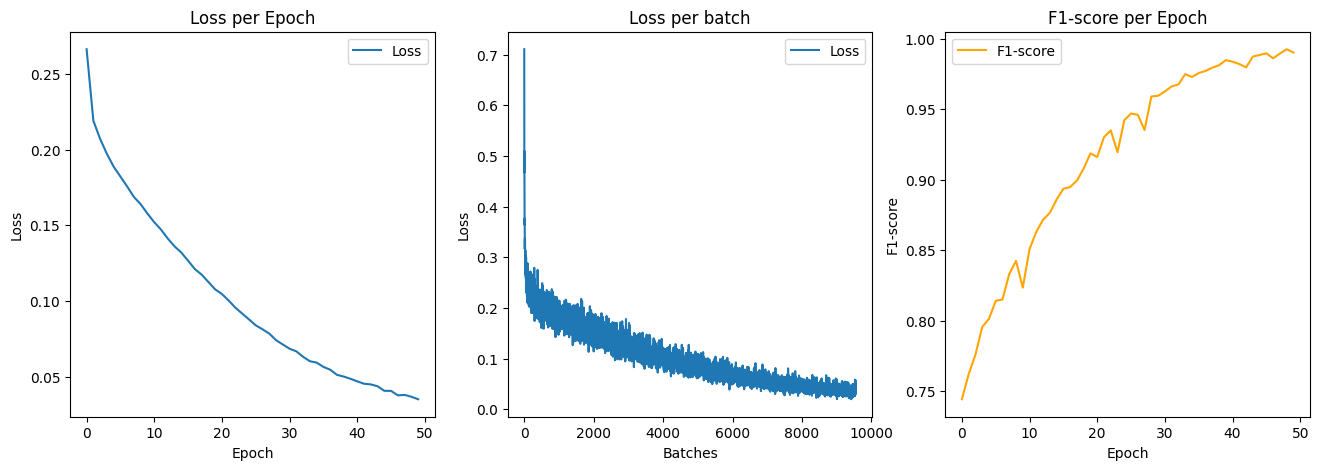

In [9]:
dropout_rate = 0.2
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3, num_epoch=50)
model.plot_metrics(X_test, y_test)

In [10]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
embedding_model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased")
def text_to_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def check_ur_comment(comment:str):
    my_comment_embedding = text_to_embedding(comment)
    my_comment_tensor = torch.tensor(my_comment_embedding, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(my_comment_tensor.unsqueeze(0).to(device))
    preds_squeezed = preds.squeeze(1).squeeze(1)
    return round(preds_squeezed.item()*100,2)

In [12]:
check_ur_comment("идиот и долбаеб")

99.98

In [13]:
check_ur_comment("красавчик")

0.0

In [14]:
check_ur_comment("ты не прав, иди учи базу")

73.79

In [15]:
check_ur_comment("красивый идиот")

88.63

In [16]:
check_ur_comment("сказочный долбаеб")

99.99

In [17]:
check_ur_comment("тупорылая работа")

99.92

In [20]:
torch.save(model.state_dict(), '../backend/nn_model/model_weights.pt')